<a href="https://colab.research.google.com/github/harttu/annotation_consistency_checker/blob/main/s800Analyze_v4_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S800 vs. LINNAEUS diff tool

*   List item
*   List item



Generates HTML fiels for comparing S800 incorpus annotations 

## Import libraries


In [48]:
import re
from google.colab import files
import csv
import re
import IPython
import pandas as pd


In [49]:
ls

common_names.txt  linnaeus.tar.gz  s800.tar.gz
linnaeus-corpus/  s800/            sample_data/


#Download Data


Download the LINNAEUS standoff data

In [50]:
cd /content/

/content


In [51]:
!wget https://github.com/harttu/linneaus_s800_comparison/raw/master/linnaeus.tar.gz 1>/dev/null

--2021-06-01 17:42:34--  https://github.com/harttu/linneaus_s800_comparison/raw/master/linnaeus.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/harttu/linnaeus_s800_comparison/raw/master/linnaeus.tar.gz [following]
--2021-06-01 17:42:34--  https://github.com/harttu/linnaeus_s800_comparison/raw/master/linnaeus.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/harttu/linnaeus_s800_comparison/master/linnaeus.tar.gz [following]
--2021-06-01 17:42:34--  https://raw.githubusercontent.com/harttu/linnaeus_s800_comparison/master/linnaeus.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

Unzip it and make some examinations

In [52]:
!tar zxvf linnaeus.tar.gz 1>/dev/null

###Download the s800 standoff data


In [53]:
!wget https://github.com/harttu/LINNEAUS_s800_comparison/raw/master/s800.tar.gz 1>/dev/null

--2021-06-01 17:42:35--  https://github.com/harttu/LINNEAUS_s800_comparison/raw/master/s800.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/harttu/linnaeus_s800_comparison/raw/master/s800.tar.gz [following]
--2021-06-01 17:42:35--  https://github.com/harttu/linnaeus_s800_comparison/raw/master/s800.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/harttu/linnaeus_s800_comparison/master/s800.tar.gz [following]
--2021-06-01 17:42:36--  https://raw.githubusercontent.com/harttu/linnaeus_s800_comparison/master/s800.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

In [54]:
!tar zxvf s800.tar.gz 1>/dev/null


In [55]:
!ls s800/split-standoff/train | head -3

19667393.ann
19667393.txt
20044015.ann


In [56]:
!ls linnaeus-corpus/split-standoff/train | head -3

pmcA102792.ann
pmcA102792.txt
pmcA1131934.ann


In [57]:
!ls s800

conll		 README.md	  split_s800.sh   standoff2conll
convert_s800.sh  S800-1.0.tar.gz  split-standoff  tools
original-data	 split		  standoff


###Download common names, which is a list of general names


In [58]:
!wget https://github.com/harttu/linneaus_s800_comparison/raw/master/common_names.txt 1>/dev/null

--2021-06-01 17:42:37--  https://github.com/harttu/linneaus_s800_comparison/raw/master/common_names.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/harttu/linnaeus_s800_comparison/raw/master/common_names.txt [following]
--2021-06-01 17:42:38--  https://github.com/harttu/linnaeus_s800_comparison/raw/master/common_names.txt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/harttu/linnaeus_s800_comparison/master/common_names.txt [following]
--2021-06-01 17:42:38--  https://raw.githubusercontent.com/harttu/linnaeus_s800_comparison/master/common_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [59]:
common_names = []
common_names_file = open("common_names.txt","r")
common_names = [ i for i in common_names_file.readlines() ]
common_names_file.close()

In [60]:
species_set_common_names = set([ name.strip() for name in common_names ])

In [61]:
len(species_set_common_names)

43499

## Get annos of all the files

In [62]:
def create_document_data(dir):
  splits = {"train":dir+"/split/train.txt","test":dir+"/split/test.txt","devel":dir+"/split/devel.txt"}
  dir_to_standoff = dir+"/standoff/"

  Data = {};

  for split_name in ["train", "test", "devel"]:
    a_file = open(splits[split_name])
    for sample_number in a_file.readlines()[0:]:
      sample_number = sample_number.strip()
      a_txt_file = open(dir_to_standoff+sample_number+".txt")
      an_ann_file = open(dir_to_standoff+sample_number+".ann")

      file_content = a_txt_file.read()
      Data[sample_number] = {"text": file_content, "annotations":[]}#, "unannotations":[]} 

      for ann_iter in an_ann_file.readlines():
        species_match = re.search("Species (\d+) (\d+)\t(.*)$", ann_iter, flags = 0) 
        if species_match != None:
          species_match_begin = int(species_match.group(1)) 
          species_match_end = int(species_match.group(2))
          species_match_str = str(species_match.group(3))
          #if sample_number not in s800Data.keys():
          Data[sample_number]["annotations"].append({"NCBI":species_match_str,"species":file_content[species_match_begin:species_match_end],"begin":species_match_begin,"end":species_match_end})  
      
      a_txt_file.close()
      an_ann_file.close()

    a_file.close()
    return Data

In [63]:
def get_annotations(dir):
  # splits have information, which file begins to which category
  splits = {"train":dir+"/split/train.txt","test":dir+"/split/test.txt","devel":dir+"/split/devel.txt"}
  dir_to_standoff = dir+"/standoff/"

  species_set = set();

  for split_name in ["train", "test", "devel"]:
    a_file = open(splits[split_name])
    for filename_begin in a_file.readlines()[0:]:
      a_txt_file = open(dir_to_standoff+filename_begin.strip()+".txt")
      an_ann_file = open(dir_to_standoff+filename_begin.strip()+".ann")

      file_content = a_txt_file.read()
      species_for_ann_file = {}
      for ann_iter in an_ann_file.readlines():
        #return ann_iter
        species_match = re.search("Species (\d+) (\d+)\t(.*)$", ann_iter, flags = 0) 
        if species_match != None:
          species_match_begin = int(species_match.group(1)) 
          species_match_end = int(species_match.group(2)) 
          species_match_string = str(species_match.group(3))
          #print(species_match_string)
          #return 0
          species_set.add(species_match_string)
          #if file_content[species_match_begin:species_match_end] not in species_for_ann_file.keys():
          #  species_for_ann_file[file_content[species_match_begin:species_match_end]] = {'O':0,'Species':0}
          #species_for_ann_file[file_content[species_match_begin:species_match_end]]['Species'] += 1
      #for species_elem in species_for_ann_file:
        #if species_elem not in species_LINNAEUS.keys():
            #species_LINNAEUS[species_elem] = {'O':0,'Species':0}
        #species_LINNAEUS[species_elem]['Species'] += species_for_ann_file[species_elem]['Species']
      a_txt_file.close()
      an_ann_file.close()

    a_file.close()

    return species_set

species_linnaeus dictionary - contains species name as keyword and 'O' and 'Species' tags to refer how many words were annotated as them in the corpus. Such as species_LINNAEUS['yeast'] is {'O': 0, 'Species': 96}.

In [64]:
species_set_LINNAEUS = get_annotations("linnaeus-corpus")
species_set_S800 = get_annotations("s800")


In [65]:
len(species_set_LINNAEUS.intersection(species_set_S800))

57

In [66]:
len(species_set_S800.intersection(species_set_common_names))

90

In [67]:
documents_S800 = create_document_data("s800")
documents_LINNAEUS = create_document_data("linnaeus-corpus")

In [68]:
#documents_S800

In [69]:
list(documents_S800.keys())[0:2]

['19667393', '20044015']

In [70]:
species_set_union = species_set_S800.union(species_set_LINNAEUS)

In [71]:
if False:
  i = 0
  for char in doc["text"]:
    print(str(i)+"\t"+char+"\t"+str(annos[i]))
    i += 1

In [72]:
#speciesDict

In [73]:
#for doc in documents__S800:
#  print(doc)
#  break

In [74]:
# go through all the species key 
#   for every document
#     find all instances of species key in doc
#       if it is not in the range of any annotation, increase species variable, if not increase 'O' varible

def form_info(speciesDict,documentList,documentName):
  speciesList = list(speciesDict.keys())
  keySpecies = documentName+"_Species"
  keyO = documentName+"_O"
  for species in speciesDict.keys():
    speciesDict[species][keySpecies] = 0
    speciesDict[species][keyO] = 0
  counter_species = 0
  for species in speciesList:
    counter_species += 1
    print('\r'+str(counter_species)+" of "+str(len(speciesList)), end='', flush=True)
    #print(str(counter_species)+" of "+str(len(speciesList)), sep=' ', end='\r', flush=True)
    for documentKey in list(documentList.keys()):
      #print("document:"+documentKey)
      document = documentList[documentKey]
      #print(document["text"])
      # make a list of zeros and ones, indicating whether there is a species in certain place
      #annos = [0] * len(document["text"]);
      #for anno in document["annotations"]:
      #  begin = anno["begin"]
      #  end = anno["end"]
      #  annos[begin:end] = [1] * (end - begin)
      annos = [ {"begin":x["begin"],"end":x["end"] } for x in document["annotations"] ]
      for match in re.finditer("(^| |\\()("+re.escape(species)+")[\\ \\. \\,\\(\\)]",document["text"]):
        ##print("Match - start:"+str(match.start(2))+" end:"+str(match.end(2)))
        ##print(document["text"][match.start(2):match.end(2)])
        start = match.start(2)
        end = match.end(2)
        inList = False
        for anno in annos:
          ##print("anno"+str(anno["begin"]))
          ##print("\t"+str(start))
          if start == anno["begin"] and end == anno["end"]:
            speciesDict[species][keySpecies] += 1
            inList = True
            ##print("\t\tIt is a match")
            break
          elif anno["begin"] <= start and end <= anno["end"]:
            #speciesDict[species][keySpecies] += 1
            inList = True
            ##print("\t\tMatches in already tagged")
            break
          if end < anno["end"]:
            ##print("\t\tSkipping")
            break
        if inList == False:
          ##print("\tDiscarded")
          speciesDict[species][keyO] += 1  
        #continue

  return speciesDict


In [75]:
speciesDict = {}
for species in species_set_union:
  speciesDict[species] = {}

speciesDict = form_info(speciesDict,documents_S800,"S800")

1266 of 1266

In [76]:
speciesDict = form_info(speciesDict,documents_LINNAEUS,"LINNAEUS")

1266 of 1266

In [77]:
speciesDictForPandas = {}

for species in speciesDict:
  S = speciesDict[species]
  speciesDictForPandas[species] = [S["S800_Species"],S["S800_O"],S["LINNAEUS_Species"],S["LINNAEUS_O"]]


In [78]:
speciesDict["Potato leaf roll virus"]

{'LINNAEUS_O': 0, 'LINNAEUS_Species': 0, 'S800_O': 0, 'S800_Species': 1}

In [79]:
 data = pd.DataFrame.from_dict(speciesDictForPandas, orient='index',
                       columns=['S800_S', 'S800_O', 'LIN_S', 'LIN_O'])

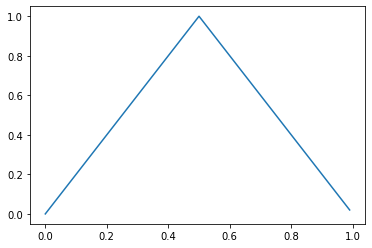

In [112]:
import matplotlib.pyplot as plt
from math import sin
import numpy

x = 1
x = numpy.arange(0,1,0.01)

function = [1 - abs( i - 0.5 ) for i in numpy.arange(0, 1, 0.001)]
#plt.xlim(0,1)
#plt.plot([x in range(0,1,0.01)],function)
plt.plot(x, 1 - 2*abs( x - 0.5))

In [93]:
data.iloc[1]

S800_S               1.0
S800_O               0.0
LIN_S                0.0
LIN_O                0.0
S800_O_per_SplusO    0.0
S800_SplusO          1.0
S800_StimesO         0.0
S800_Oimp            0.0
S800_Oimp_05         0.5
S800_Oimp_05_2       0.5
Name: Diabrotica virgifera virgifera (LeConte), dtype: float64

In [ ]:
Report_Card.loc[(Data["Name"]=="Benjamin Duran") & (Report_Card["Lectures"] == "Mathematics")]

In [106]:
data.index

Index(['Grapholita molesta', 'Diabrotica virgifera virgifera (LeConte)',
       'D. melanogaster', 'Oramoeba fumarolia', 'Lucilia sericata', 'Mink',
       'Ebola virus', 'housefly', 'SINV', 'adenoviral',
       ...
       'Matricaria chamomilla', 'Aspergillus fumigatuscyp51A',
       'S. richteri Forel', 'Geleia sinica spec. nov.',
       'Aureococcus anophagefferens',
       'Flavobacterium gelidilacus LMG 21477(T)', 'black truffle',
       'white spot syndrome virus', 'Sindbis', 'Rumex palustris'],
      dtype='object', length=1266)

In [114]:
data.loc[data.index == "patient"]

,S800_S,S800_O,LIN_S,LIN_O,S800_O_per_SplusO,S800_SplusO,S800_StimesO,S800_Oimp,S800_Oimp_05,S800_Oimp_05_2
patient,0,12,36,0,1.0,12.0,0.0,0.0,0.0,0.0


In [128]:
data['S800_O_per_SplusO'] = data.apply(lambda row: row.S800_O / (row.S800_S + row.S800_O), axis=1)
data['LIN_O_per_SplusO'] = data.apply(lambda row: row.LIN_O / (row.LIN_S + row.LIN_O), axis=1)

data['S800_SplusO'] = data.apply(lambda row: (row.S800_S + row.S800_O), axis=1)
data['LIN_SplusO'] = data.apply(lambda row: (row.LIN_S + row.LIN_O), axis=1)

data['S800_StimesO'] = data.apply(lambda row: (row.S800_S * row.S800_O), axis=1)
#data['S800_Oimp'] = data.apply(lambda row: ( 1.0 if row.S800_S > 0 else 0.0 ) * ( float(row.S800_O_per_SplusO) * row.S800_O ), axis=1).astype('float64')
data['S800_Oimp_05'] = data.apply(lambda row: ( 1 - 2 * abs(row.S800_O_per_SplusO - 0.5)) * row.S800_SplusO , axis=1).astype('float64')
data['LIN_Oimp_05'] = data.apply(lambda row: ( 1 - 2 * abs(row.LIN_O_per_SplusO - 0.5)) * row.LIN_SplusO  , axis=1).astype('float64')

#data.sort_values(by=['S800_Oimp_05'],ascending=False, na_position='last').head(50)
data.sort_values(by=['LIN_Oimp_05'],ascending=False, na_position='last').head(50)

print(data['LIN_Oimp_05'].sum() / data['LIN_S'].sum())

print(data['S800_Oimp_05'].sum() / data['S800_S'].sum())

#data.search("patient")

0.025303643724696356
0.13546487168700042


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [35]:
for annos in documents_S800["21441069"]["annotations"]:
  print(annos["species"])

In [36]:
for species in speciesDict.keys():
  Species = speciesDict[species]
  if Species["S800_Species"] > 0 or Species["S800_O"] > 0:
    print("Species:"+species+" - "+str(Species["S800_Species"])+" - "+str(Species["S800_O"]))
#print(speciesDict["SMSP(T)"])
#print(speciesDict["Methanoregula formicica"])
#print(speciesDict["Methanoregula boonei"])
#print(speciesDict["Methanoregula boonei 6A8"])

Species:Grapholita molesta - 1 - 0
Species:Diabrotica virgifera virgifera (LeConte) - 1 - 0
Species:D. melanogaster - 4 - 0
Species:Oramoeba fumarolia - 2 - 0
Species:Lucilia sericata - 2 - 0
Species:Mink - 1 - 0
Species:Ebola virus - 3 - 0
Species:housefly - 3 - 0
Species:adenoviral - 1 - 0
Species:yellow morels - 1 - 0
Species:human - 51 - 6
Species:yeasts - 2 - 3
Species:Auricularia auricula-judae - 1 - 0
Species:Marinobacterium maritimum - 1 - 0
Species:H. werneckii - 1 - 0
Species:F. oxysporum transformant - 1 - 0
Species:mice - 22 - 10
Species:A/AV88(L) - 1 - 0
Species:Maribacter sp. strain HTCC2170 - 1 - 0
Species:baculoviruses - 1 - 0
Species:Pseudomonas syringae pv. tomato - 1 - 0
Species:B. mori - 2 - 0
Species:murine leukemia virus (F-MuLV) - 1 - 0
Species:varicella-zoster virus - 1 - 0
Species:Spirochaeta litoralis - 1 - 0
Species:Pectinophora gossypiella - 2 - 0
Species:Triticum durum - 1 - 0
Species:Parvularcula bermudensis - 2 - 0
Species:PLRV - 1 - 0
Species:RCNMV - 3 -

In [37]:
documents_S800["21441069"]["text"]

'Preventive therapy for breast cancer: a consensus statement.\n\nIn March, 2010, a group of breast cancer experts met to develop a consensus statement on breast cancer prevention, with a focus on medical and therapeutic interventions. We present the conclusions in this Review. First we agreed that the term chemoprevention is inappropriate and suggested that the term preventive therapy better represents this feature of management. Two selective oestrogen-receptor modulators--tamoxifen and raloxifene--are so far the only medical options approved by the US Food and Drug Administration for preventive therapy. Of these tamoxifen has greater efficacy and can be used in premenopausal women, but raloxifene has fewer side-effects. Two newer drugs in this class, lasofoxifene and arzoxifene, also show efficacy and possibly a better overall risk-benefit profile, but need further assessment. Aromatase inhibitors might be more efficacious, and results of prevention trials are eagerly awaited. Newer 

In [38]:
splits = {"train":"split/train.txt","test":"split/test.txt","devel":"split/devel.txt"}
dir_to_standoff = "standoff/"

species_LINNAEUS = {};

for split_name in ["train", "test", "devel"]:
  a_file = open(splits[split_name])
  for filename_begin in a_file.readlines()[0:]:
    a_txt_file = open(dir_to_standoff+filename_begin.strip()+".txt")
    an_ann_file = open(dir_to_standoff+filename_begin.strip()+".ann")

    file_content = a_txt_file.read()
    species_for_ann_file = {}
    for ann_iter in an_ann_file.readlines():
      species_match = re.search("Species (\d+) (\d+)", ann_iter, flags = 0) 
      if species_match != None:
        species_match_begin = int(species_match.group(1)) 
        species_match_end = int(species_match.group(2)) 
        if file_content[species_match_begin:species_match_end] not in species_for_ann_file.keys():
          species_for_ann_file[file_content[species_match_begin:species_match_end]] = {'O':0,'Species':0}
        species_for_ann_file[file_content[species_match_begin:species_match_end]]['Species'] += 1
    for species_elem in species_for_ann_file:
      if species_elem not in species_LINNAEUS.keys():
          species_LINNAEUS[species_elem] = {'O':0,'Species':0}
      species_LINNAEUS[species_elem]['Species'] += species_for_ann_file[species_elem]['Species']
    a_txt_file.close()
    an_ann_file.close()

  a_file.close()

FileNotFoundError: ignored

In [ ]:
list(species_LINNAEUS.keys())[0:5]

In [ ]:
species_LINNAEUS['yeast']

LINNAEUS
Data - contains sample numbers, text and annotations. Such as LINNAEUSData["pmcA102792"] contains list, which contains following elements: 'annotations' ( list of e.g {'begin': 1851,
   'end': 1873,
   'is_annotated': True,
   'species': 'Caenorhabditis elegans'}, ... ) and 'text': 'Scp160p, a multiple KH-domain protein, is a component of mRNP complexes in yeast\nAb...

In [ ]:
splits = {"train":"split/train.txt","test":"split/test.txt","devel":"split/devel.txt"}
dir_to_standoff = "standoff/"

LINNAEUSData = {};


for split_name in ["train", "test", "devel"]:
  a_file = open(splits[split_name])
  for sample_number in a_file.readlines()[0:]:
    sample_number = sample_number.strip()
    a_txt_file = open(dir_to_standoff+sample_number+".txt")
    an_ann_file = open(dir_to_standoff+sample_number+".ann")

    file_content = a_txt_file.read()
    LINNAEUSData[sample_number] = {"text": file_content, "annotations":[]}#, "unannotations":[]} 

    for ann_iter in an_ann_file.readlines():
      species_match = re.search("Species (\d+) (\d+)", ann_iter, flags = 0) 
      if species_match != None:
        species_match_begin = int(species_match.group(1)) 
        species_match_end = int(species_match.group(2))
        #if sample_number not in s800Data.keys():
        LINNAEUSData[sample_number]["annotations"].append({"is_annotated":True,"species":file_content[species_match_begin:species_match_end],"begin":species_match_begin,"end":species_match_end})  
    
    a_txt_file.close()
    an_ann_file.close()

  a_file.close()

A quick demo of LINNAEUSData

In [ ]:
LINNAEUSData["pmcA102792"]["annotations"][-1]

In [ ]:
LINNAEUSData["pmcA102792"]["annotations"][1]

In [ ]:
LINNAEUSData["pmcA102792"]["text"][126:131]

In [ ]:
LINNAEUSData["pmcA102792"]["text"]

In [ ]:
LINNAEUSData["pmcA102792"]["text"][32625:32637]

In [ ]:
 LINNAEUSData["pmcA102792"]["text"][32287:32292]

To get unannotated species we must for travel through every document and find species that are not within the already tagged entities

In [ ]:
re.escape(" "+"S.cerevisiae")+"[\\ \\. \\,]"

In [ ]:
# for further analysis
#[{"is_annotated":False,"species":specie,"begin":m.start(0)+1,"end":m.end(0)-1} for m in re.finditer(re.escape(" "+'S.cerevisiae')+"[\\ \\. \\,]", tmp92)]

In [ ]:
splits = {"train":"split/train.txt","test":"split/test.txt","devel":"split/devel.txt"}
dir_to_standoff = "standoff/"
matches_in_doc = [];


for split_name in ["train", "test", "devel"]:
  a_file = open(splits[split_name])
  # for each document
  for sample_number in a_file.readlines()[0:]:
    sample_number = sample_number.strip()
    a_txt_file = open(dir_to_standoff+sample_number+".txt")
    an_ann_file = open(dir_to_standoff+sample_number+".ann")

    file_content = a_txt_file.read()
    #print(file_content);
    #break;
    not_annotated_species = []
    # for each tagged species in species_LINNAEUS( 'yeast', 'Saccharo...', ...)
    for specie in species_LINNAEUS:
      # this is tough, matches_in_doc e.g. 
      # for sample pmcA102792 and species 'yeast':
      # [{'is_annotated': False, 'species': ['yeast', 'begin': 126, 'end': 131}, ... ,{'is_annotated': False, 'species': 'yeast', 'begin': 32287, 'end': 32292}]        
      # so it finds all the species that are annotated in LINNAEUS altogether and sets is_annotated flag by default to be False
      matches_in_doc = [{"is_annotated":False,"species":specie,"begin":m.start(0)+1,"end":m.end(0)-1} for m in re.finditer(re.escape(" "+specie)+"[\\ \\. \\,]", file_content)]
      # a small test
      # test if the last species of the first article is 
      if sample_number == "pmcA102792" and 1 == 0:
        if specie == "S.cerevisiae":
          print(matches_in_doc[-1]["begin"]);
          print(LINNAEUSData["pmcA102792"]["annotations"][-1]["begin"]);
          assert matches_in_doc[-1]["begin"] == LINNAEUSData["pmcA102792"]["annotations"][-1]["begin"];
          assert matches_in_doc[-1]["end"] == LINNAEUSData["pmcA102792"]["annotations"][-1]["end"];
          print("Test pmcA102792 S.cerevisiae test passed");

      # a test hack
      #matches_in_doc.append({"is_annotated":False,"species":"yeast","begin":5,"end":10});
      # now we go through every element in matches_in_doc
      # LINNAEUSData already contains tagged species in a document, such as : {'begin': 32625, 'end': 32637, 'is_annotated': True, 'species': 'S.cerevisiae'}
      for false_candidate in matches_in_doc:
        validTillEnd = True
        for annotation in LINNAEUSData[sample_number]["annotations"]:
          if annotation["is_annotated"] == False:
            break;
          # for example
          # 'Drosophila' is not added in the following case as it is in the range. So if there is any overlap, between existing annotation, nothing is added
          # {'begin': 3756, 'end': 3779, 'is_annotated': True,  'species': 'Drosophila melanogaster'},
          # where as {'is_annotated': False, 'species': 'Drosophila', 'begin': 4426, 'end': 4436} validates since
          # LINNAEUSData["pmcA102792"]["annotations"] contains
          # ...
          # {'begin': 4085, 'end': 4090, 'is_annotated': True, 'species': 'human'},
          # {'begin': 4760, 'end': 4765, 'is_annotated': True, 'species': 'yeast'},
          # ...
          if annotation["begin"] <= false_candidate["begin"] and false_candidate["end"] <= annotation["end"]:
            validTillEnd = False
            #break
        if validTillEnd:
          #print("Added");
          #print(false_candidate);
          LINNAEUSData[sample_number]["annotations"].append(false_candidate)
    break;
    a_txt_file.close()
    an_ann_file.close()

  a_file.close()

In [ ]:
LINNAEUSData["pmcA102792"]["annotations"];

Get 'O' to species_LINNAEUS dict

In [ ]:
for LINNAEUS_key in LINNAEUSData.keys():
  for ann in LINNAEUSData[LINNAEUS_key]["annotations"]:
    if ann["is_annotated"] == False:
      species_LINNAEUS[ann["species"]]['O'] += 1

### Make HTML files for better viewing


In [ ]:
LINNAEUS_ambiguous_html="LINNAEUS_ambiguous_html"
!rm -rf LINNAEUS_ambiguous_html/
!mkdir -p LINNAEUS_ambiguous_html

#### HTML pages formatting

In [ ]:
afterHTML="""
<!doctype html><html lang=\"en\"> <head><meta charset=\"utf-8\"> 
<title>LINNAEUS inconsistencies</title> 
<style>  
.yellow { background-color:rgba(50, 180, 180, 0.5); } 
.red { background-color:rgba(214, 75, 79, 0.5); } 
.blue { background-color:rgba(75, 75, 214, 0.5); } 
table { border-collapse: collapse; } 
th, td { border: 1px solid black; padding: 4px; } 
th {  cursor: pointer; } 
th:hover { background: yellow; }
</style></head><body>
"""

linkPagecontent="""
<small><b>Press header for sorting</b></small>
<table id=\"grid\"> 
    <thead> 
      <tr> 
        <th data-type=\"string\">Tagged entity</th> 
        <th data-type=\"number\">'Species' tags</th> 
        <th data-type=\"number\">'O' tags</th> 
      </tr> 
    </thead> 
    <tbody>
"""
#"<table><tr><th>Tagged entity</th><th>'Species' tags</th><th>'O' tags</th></tr>"
linkPagecontent_end = """
</tbody>
</body> 
  <script>  

    grid.onclick = function(e) {
      if (e.target.tagName != 'TH') return;

      let th = e.target;
      // if TH, then sort
      // cellIndex is the number of th:
      //   0 for the first column
      //   1 for the second column, etc
      sortGrid(th.cellIndex, th.dataset.type);
    };

    function sortGrid(colNum, type) {
      let tbody = grid.querySelector('tbody');

      let rowsArray = Array.from(tbody.rows);

      // compare(a, b) compares two rows, need for sorting
      let compare;

      switch (type) {
        case 'number':
          compare = function(rowA, rowB) {
            return rowA.cells[colNum].innerHTML - rowB.cells[colNum].innerHTML;
          };
          break;
        case 'string':
          compare = function(rowA, rowB) {
            return rowA.cells[colNum].innerHTML > rowB.cells[colNum].innerHTML ? 1 : -1;
          };
          break;
      }

      // sort
      rowsArray.sort(compare);

      tbody.append(...rowsArray);
    }
  </script>
</html>
"""

endHTML="</body></html>"


##### Make HTML files

In [ ]:

#s800_ambiguous_html = "s800_ambiguous_html"


for species_key in species_LINNAEUS.keys():
  species_html_content = "<h2>"+species_key+"</h2>"
  species_html_content += "<span class=\"red\">Not tagged name</span> - <span class=\"blue\">Tagged name</span> - <span class=\"yellow\">Other name</span><br><hr>"
  nameInLinkPage = species_key
  trigger = False
  for document_key in LINNAEUSData.keys():
      filtered_species = []
      for candidate in LINNAEUSData[document_key]["annotations"]:
        if candidate['species'] == species_key:
          filtered_species.append(candidate)
      if len(list(filtered_species)) > 0:
        trigger = True
        species_html_content += "<h3>"+document_key+"</h3>"
        species_to_html = sorted(LINNAEUSData[document_key]["annotations"], key = lambda i: i['begin'])
        tmp_begin = 0
        if document_key == "20173005" and species_key == "yeast":
          print(species_to_html)
        for current in species_to_html:
          if current["species"] == species_key:
            if current["is_annotated"] == True:
              species_html_content += LINNAEUSData[document_key]["text"][tmp_begin:current["begin"]] + "<span class=\"blue\">" + current["species"] + "</span>"
            else:
              species_html_content += LINNAEUSData[document_key]["text"][tmp_begin:current["begin"]] + "<span class=\"red\">" + current["species"] + "</span>"
          else:
            species_html_content += LINNAEUSData[document_key]["text"][tmp_begin:current["begin"]] + "<span class=\"yellow\">" + current["species"] + "</span>"
          tmp_begin = current["end"]
        species_html_content += LINNAEUSData[document_key]["text"][tmp_begin:]
  if trigger == True:
    filename = "".join(x for x in species_key if x.isalnum())+".html"
    f = open(LINNAEUS_ambiguous_html+"/"+filename, "w")
    # make the headline of each document on its own line
    species_html_content = re.sub("\n\n","<br><br>",species_html_content)
    f.write(afterHTML+species_html_content+endHTML)
    f.close()
    nameInLinkPage = "<a href=\""+filename+"\">"+species_key+"</a>"
  linkPagecontent += "<tr><td>"+nameInLinkPage+"</td><td>"+str(species_LINNAEUS[species_key]['Species'])+"</td><td>"+str(species_LINNAEUS[species_key]['O'])+"</td></tr>\n"
  #key+"<br />\n"
linkPagecontent += "</table>"
f = open(LINNAEUS_ambiguous_html+"/index.html", "w")
f.write(afterHTML+linkPagecontent+linkPagecontent_end)
f.close()

In [ ]:
ls LINNAEUS_ambiguous_html

adenovirus.html                         men.html
Alliumsativum.html                      Men.html
Aloevera.html                           Mgrisea.html
Ancylostomacaninum.html                 mice.html
Ancylostomaceylanicum.html              Mice.html
Ancylostomaduodenale.html               Mleprae.html
Anisakissimplex.html                    MMTV.html
Anophelesgambiae.html                   moth.html
anthrax.html                            mouse.html
Arabidopsis.html                        Mouse.html
Arabidopsisthaliana.html                MRSA.html
Armenianhamster.html                    Msmegmatis.html
Ascarissuum.html                        Mtb.html
Ashbyagossypii.html                     Mtuberculosis.html
Aspergillusnidulans.html                mules.html
Asuum.html                              murine.html
Athaliana.html                          Murine.html
Atlanticsalmon.html                     Musmusculus.html
avianmyeloblastosisvirus.html           Mycobacteriumafricanum.html


##### Some examinations of newly created data

In [ ]:
#IPython.display.HTML(filename='LINNAEUS_ambiguous_html/human.html')

#####Prepare a gzip and download

In [ ]:
html_tar_file = LINNAEUS_ambiguous_html+".tar.gz"
!tar -czvf $html_tar_file LINNAEUS_ambiguous_html 1>/dev/null

In [ ]:
files.download(html_tar_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#S800 PART


##Data preparation

###species dictionary - contain species name as key and 'O' and 'Species' tags to refer how many words were annotated as them in the corpus


In [ ]:
splits = {"train":"split/train.txt","test":"split/test.txt","devel":"split/devel.txt"}
dir_to_standoff = "standoff/"

species = {};

#s800SpeciesMarkedData = []

for split_name in ["train", "test", "devel"]:
  a_file = open(splits[split_name])
  for filename_begin in a_file.readlines()[0:]:
    a_txt_file = open(dir_to_standoff+filename_begin.strip()+".txt")
    an_ann_file = open(dir_to_standoff+filename_begin.strip()+".ann")

    file_content = a_txt_file.read()
    species_for_ann_file = {}
    #
    # We want to add species in a file, to a dict and if they are already present in the dict as a key, increase the value associated with the key
    # The aim is to find all the species and in the second loop form a set of them
    for ann_iter in an_ann_file.readlines():
      species_match = re.search("Species (\d+) (\d+)", ann_iter, flags = 0) 
      if species_match != None:
        species_match_begin = int(species_match.group(1)) 
        species_match_end = int(species_match.group(2))
        # check if Species has been already added
        if file_content[species_match_begin:species_match_end] not in species_for_ann_file.keys():
          # no, init dict
          species_for_ann_file[file_content[species_match_begin:species_match_end]] = {'O':0,'Species':0}
        # yes, increase counter
        species_for_ann_file[file_content[species_match_begin:species_match_end]]['Species'] += 1
    # 
    # now add them to the super list containing all the species mentioned so far
    for species_elem in species_for_ann_file:
      # a new species found, init its values
      if species_elem not in species.keys():
          species[species_elem] = {'O':0,'Species':0,'Species_LINNAEUS':0}
      #print(len(re.findall(re.escape(species_elem),file_content)))
      #species[species_elem]['O'] += len(re.findall(re.escape(species_elem),file_content)) - species_for_ann_file[species_elem]['Species']
      #
      # Add how many were present in the file
      species[species_elem]['Species'] += species_for_ann_file[species_elem]['Species']
    a_txt_file.close()
    an_ann_file.close()

  a_file.close()

In [ ]:
species["fire ant"]

{'O': 0, 'Species': 5, 'Species_LINNAEUS': 0}

Before adding LINNAEUS tags, remember the tags

In [ ]:
species_set_S800 = set(species.keys())

In [ ]:
list(species_set_S800)[0:5]

['S. richteri Forel',
 'Acer pseudoplatanus',
 'Methanothermobacter thermoautotrophicus',
 'anthrax',
 'G. biloba']

###s800Data - contains sample numbers, text and annotations

In [ ]:
splits = {"train":"split/train.txt","test":"split/test.txt","devel":"split/devel.txt"}
dir_to_standoff = "standoff/"

s800Data = {};


for split_name in ["train", "test", "devel"]:
  a_file = open(splits[split_name])
  for sample_number in a_file.readlines()[0:]:
    sample_number = sample_number.strip()
    a_txt_file = open(dir_to_standoff+sample_number+".txt")
    an_ann_file = open(dir_to_standoff+sample_number+".ann")

    file_content = a_txt_file.read()
    s800Data[sample_number] = {"text": file_content, "annotations":[]}#, "unannotations":[]} 

    for ann_iter in an_ann_file.readlines():
      species_match = re.search("Species (\d+) (\d+)", ann_iter, flags = 0) 
      if species_match != None:
        species_match_begin = int(species_match.group(1)) 
        species_match_end = int(species_match.group(2))
        #if sample_number not in s800Data.keys():
        s800Data[sample_number]["annotations"].append({"is_annotated":True,"only_in_LINNAEUS":False,"species":file_content[species_match_begin:species_match_end],"begin":species_match_begin,"end":species_match_end})  
    
    a_txt_file.close()
    an_ann_file.close()

  a_file.close()

In [ ]:
s800Data["21029750"]["annotations"][0]

{'begin': 13,
 'end': 41,
 'is_annotated': True,
 'only_in_LINNAEUS': False,
 'species': 'infectious myonecrosis virus'}

In [ ]:
s800Data["21029750"]["text"]

'Detection of infectious myonecrosis virus using monoclonal antibody specific to N and C fragments of the capsid protein expressed heterologously. \n\nThe gene encoding the capsid protein in ORF1 of the genome of infectious myonecrosis virus (IMNV) (GenBank AY570982) was amplified into three parts named CP-N (nucleotides 2248-3045), CP-I (nucleotides 3046-3954) and CP-C (nucleotides 3955-4953). The CP-N fragment was inserted into expression vector pTYB1 while CP-I and CP-C were each inserted into expression vector pGEX-6P-1 for transformation of BL21 E. coli strain. After induction, intein-CP-N (84 kDa), glutathione-S-transferase (GST)-CP-I (60 kDa) and GST-CP-C (62 kDa) fusion proteins were produced. They were separated by SDS-PAGE and electroeluted before immunization of Swiss mice for monoclonal antibody (MAb) production. Two MAbs specific to CP-N and one MAb specific to CP-C were selected for use for detection of natural IMNV infections in Penaeus vannamei by dot blotting, Western 

#### Compare entities that are not s800 but in LINNAEUS

In [ ]:
keys_only_in_LINNAEUS = []
for candidate_key in species_LINNAEUS.keys():
  if candidate_key not in species.keys():
    keys_only_in_LINNAEUS.append(candidate_key)

In [ ]:
keys_only_in_LINNAEUS[0:8]

['S.cerevisiae',
 'Caenorhabditis elegans',
 'Xenopus laevis',
 'C.elegans',
 'E.coli',
 'bovine',
 'Pichia pastoris',
 'D.melanogaster']

In [ ]:
#for key in species_LINNAEUS.keys():
#  species[key]["Species_LINNAEUS"] = species_LINNAEUS[key]['Species']

In [ ]:
species_LINNAEUS["Men"]

{'O': 0, 'Species': 2}

In [ ]:
species_LINNAEUS["E.coli"]

{'O': 0, 'Species': 2}

In [ ]:
#species["E.coli"] # this would fail

In [ ]:
species["E. coli"]

{'O': 0, 'Species': 12, 'Species_LINNAEUS': 0}

###To get unannotated text we must for travel through every document and find species that are not within the already tagged entities

In [ ]:
# regex testing
test = "muggy rat-"
re.findall(re.escape(" "+"rat")+"[\\ \\. \\, \\-]", test)

[' rat-']

In [ ]:
splits = {"train":"split/train.txt","test":"split/test.txt","devel":"split/devel.txt"}
dir_to_standoff = "standoff/"


for split_name in ["train", "test", "devel"]:
  a_file = open(splits[split_name])
  for sample_number in a_file.readlines()[0:]:
    #if 1 == 1:
      #sample_number = "21047956\n"
    sample_number = sample_number.strip()
    a_txt_file = open(dir_to_standoff+sample_number+".txt")
    an_ann_file = open(dir_to_standoff+sample_number+".ann")

    file_content = a_txt_file.read()
    not_annotated_species = []
    for specie in species:
      matches_in_doc = [{"is_annotated":False,"only_in_LINNAEUS":False,"species":specie,"begin":m.start(0)+1,"end":m.end(0)-1} for m in re.finditer(re.escape(" "+specie)+"[\\ \\. \\, \\-]", file_content)]
      for false_candidate in matches_in_doc:
        validTillEnd = True
        #if specie == "human":
        #  print(s800Data[sample_number]["annotations"])
        for annotation in s800Data[sample_number]["annotations"]:
          #if annotation["begin"] <= false_candidate["begin"] or false_candidate["end"] <= annotation["end"]:
          if (annotation["begin"] <= false_candidate["begin"] and false_candidate["begin"] <= annotation["end"]) \
             or (annotation["begin"] <= false_candidate["end"] and false_candidate["end"] <= annotation["end"]):
            validTillEnd = False
            break
        if validTillEnd:
          #if false_candidate["species"] == "shrimp":
          #  print("Shrimp above")
          s800Data[sample_number]["annotations"].append(false_candidate)
    
    for specie in keys_only_in_LINNAEUS:
      matches_in_doc = [{"is_annotated":False,"only_in_LINNAEUS":True,"species":specie,"begin":m.start(0)+1,"end":m.end(0)-1} for m in re.finditer(re.escape(" "+specie)+"[\\ \\. \\,]", file_content)]
      for LINNAEUS_candidate in matches_in_doc:
        validTillEnd = True
        for annotation in s800Data[sample_number]["annotations"]:
          # this is to say, that the candidate is within, but it should rather work when part of the candidate is within
          #if annotation["begin"] <= LINNAEUS_candidate["begin"] and LINNAEUS_candidate["end"] <= annotation["end"]:
          if (annotation["begin"] <= LINNAEUS_candidate["begin"] and LINNAEUS_candidate["begin"] <= annotation["end"]) \
             or (annotation["begin"] <= LINNAEUS_candidate["end"] and LINNAEUS_candidate["end"] <= annotation["end"]):
            validTillEnd = False
            break
        if validTillEnd:
          #if LINNAEUS_candidate["species"] == "shrimp":
          #  print("Shrimp below")
          s800Data[sample_number]["annotations"].append(LINNAEUS_candidate)
          #print("Added "+str(LINNAEUS_candidate))

    a_txt_file.close()
    an_ann_file.close()

  a_file.close()

In [ ]:
species["HIV"]

{'O': 0, 'Species': 38, 'Species_LINNAEUS': 0}

Now add the missing keys

In [ ]:
for key in keys_only_in_LINNAEUS:
  species[key] = {'Species':0,'O':0,'Species_LINNAEUS':species_LINNAEUS[key]['Species']}

In [ ]:
species["Men"]

{'O': 0, 'Species': 0, 'Species_LINNAEUS': 2}

In [ ]:
species["HIV"]

{'O': 0, 'Species': 38, 'Species_LINNAEUS': 0}

In [ ]:
HIVspecies = 0
HIVo = 0
for key in list(s800Data.keys())[0:]:
  for ann in list(s800Data[key]["annotations"]):
    if ann['species'] == 'HIV':
      if ann['is_annotated'] == True:
        HIVspecies += 1
      if ann['is_annotated'] == False:
        HIVo += 1
print(HIVspecies)
print(HIVo)

38
13


#### 'only_in_LINNAEUS' tagged species should be denoted by 'O' in the dataset

In [ ]:
for sample in s800Data.keys():
  for ann in s800Data[sample]["annotations"]:
    if ann["only_in_LINNAEUS"]:
      #print(ann["species"]+" "+sample)
      species[ann["species"]]['O'] += 1

In [ ]:
s800Data[list(s800Data.keys())[0]]

{'annotations': [{'begin': 0,
   'end': 23,
   'is_annotated': True,
   'only_in_LINNAEUS': False,
   'species': 'Methanoregula formicica'},
  {'begin': 143,
   'end': 150,
   'is_annotated': True,
   'only_in_LINNAEUS': False,
   'species': 'SMSP(T)'},
  {'begin': 1076,
   'end': 1083,
   'is_annotated': True,
   'only_in_LINNAEUS': False,
   'species': 'SMSP(T)'},
  {'begin': 1225,
   'end': 1249,
   'is_annotated': True,
   'only_in_LINNAEUS': False,
   'species': 'Methanoregula boonei 6A8'},
  {'begin': 1423,
   'end': 1430,
   'is_annotated': True,
   'only_in_LINNAEUS': False,
   'species': 'SMSP(T)'},
  {'begin': 1435,
   'end': 1459,
   'is_annotated': True,
   'only_in_LINNAEUS': False,
   'species': 'Methanoregula boonei 6A8'},
  {'begin': 1770,
   'end': 1777,
   'is_annotated': True,
   'only_in_LINNAEUS': False,
   'species': 'SMSP(T)'},
  {'begin': 1863,
   'end': 1886,
   'is_annotated': True,
   'only_in_LINNAEUS': False,
   'species': 'Methanoregula formicica'},
  {'be

In [ ]:
species['HIV']

{'O': 0, 'Species': 38, 'Species_LINNAEUS': 0}

In [ ]:
species['men']

{'O': 1, 'Species': 0, 'Species_LINNAEUS': 80}

##### For reference

###Add 'O's to species dictionary simply looping through the previously found 


In [ ]:
for species_key in species.keys():
  species[species_key]['O'] = 0

for s800_key in s800Data.keys():
  for ann in s800Data[s800_key]["annotations"]:
    if ann["is_annotated"] == False and ann["only_in_LINNAEUS"] == False :
      species[ann["species"]]['O'] += 1

In [ ]:
species["HIV"]

{'O': 13, 'Species': 38, 'Species_LINNAEUS': 0}

In [ ]:
ls

common_names.txt  original-data/   split/           standoff/
conll/            README.md        split_s800.sh*   standoff2conll/
convert_s800.sh*  S800-1.0.tar.gz  split-standoff/  tools/


Is this already done?

In [ ]:
for s800_key in s800Data.keys():
  for ann in s800Data[s800_key]["annotations"]:
    #if ann["species"] == "men":
    #  print(s800_key)
    if ann["is_annotated"] == False and ann["only_in_LINNAEUS"] == True :
      species[ann["species"]]['O'] += 1



In [ ]:
species["men"]

{'O': 1, 'Species': 0, 'Species_LINNAEUS': 80}

In [ ]:
s800Data["20599424"]

{'annotations': [{'begin': 226,
   'end': 234,
   'is_annotated': False,
   'only_in_LINNAEUS': True,
   'species': 'patients'},
  {'begin': 116,
   'end': 119,
   'is_annotated': False,
   'only_in_LINNAEUS': True,
   'species': 'men'}],
 'text': 'Radionuclide and hybrid imaging of recurrent prostate cancer.\n\nProstate cancer is one of the most common cancers in men, leading to substantial morbidity and mortality. After definitive therapy with surgery or radiation, many patients have biochemical relapse of disease--ie, an increase in their prostate-specific antigen level--which often precedes clinically apparent disease by months or even years. Therefore, imaging of the site and extent of tumour recurrence (local, regional, distant, or a combination) is of great interest. Conventional morphological imaging methods showed limited accuracy for assessment of recurrent prostate cancer; however, in recent years, functional and molecular imaging have offered the possibility of imaging mole

In [ ]:
an_ann_file = open("standoff/20599424.ann")
for line in an_ann_file.readlines():
  print(line);


##Common names

In [ ]:
#species_set_S800 = set( [x.species for x in ]) 

In [ ]:
species_set_common = set(species_LINNAEUS.keys()).intersection(species_set_S800)

In [ ]:
list(species_set_common)[0:5]

['S. cerevisiae',
 'rhesus macaque',
 'P. aeruginosa',
 'C. pipiens',
 'Neisseria meningitidis']

In [ ]:
len(list(species.keys()))

1829

In [ ]:
len(species_LINNAEUS.keys())

419

In [ ]:
len(list(species_set_common))

93

##Download common names, which is a list of general names

In [ ]:
!wget https://github.com/harttu/linneaus_s800_comparison/raw/master/common_names.txt 1>/dev/null

--2021-05-29 14:11:53--  https://github.com/harttu/linneaus_s800_comparison/raw/master/common_names.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/harttu/linnaeus_s800_comparison/raw/master/common_names.txt [following]
--2021-05-29 14:11:53--  https://github.com/harttu/linnaeus_s800_comparison/raw/master/common_names.txt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/harttu/linnaeus_s800_comparison/master/common_names.txt [following]
--2021-05-29 14:11:53--  https://raw.githubusercontent.com/harttu/linnaeus_s800_comparison/master/common_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [ ]:
ls

common_names.txt    convert_s800.sh*  S800-1.0.tar.gz  split-standoff/  tools/
common_names.txt.1  original-data/    split/           standoff/
conll/              README.md         split_s800.sh*   standoff2conll/


In [ ]:
common_names = []
common_names_file = open("common_names.txt","r")
common_names = [ i for i in common_names_file.readlines() ]
common_names_file.close()

In [ ]:
common_names[0:5]

['eubacteria\n',
 'fruiting gliding bacteria\n',
 'Scheibenbakterien\n',
 'Scheibenbakterien Muller 1911\n',
 'Lyme disease spirochete\n']

In [ ]:
len(common_names)

44217

In [ ]:
splits = {"train":"split/train.txt","test":"split/test.txt","devel":"split/devel.txt"}
dir_to_standoff = "standoff/"


for split_name in ["train", "test", "devel"]:
  a_file = open(splits[split_name])
  for sample_number in a_file.readlines()[0:]:
    #if 1 == 1:
      #sample_number = "21047956\n"
    sample_number = sample_number.strip()
    a_txt_file = open(dir_to_standoff+sample_number+".txt")
    an_ann_file = open(dir_to_standoff+sample_number+".ann")

    file_content = a_txt_file.read()
    not_annotated_species = []

    #file_content = a_txt_file.read()
    #not_annotated_species = []
    for specie in species:
      matches_in_doc = [{"is_annotated":False,"only_in_LINNAEUS":False,"species":specie,"begin":m.start(0)+1,"end":m.end(0)-1} for m in re.finditer(re.escape(" "+specie)+"[\\ \\. \\, \\-]", file_content)]
      #for false_candidate in matches_in_doc:
      #  validTillEnd = True

    #for species in an_ann_file.readline() ?? this was added, don't know if works
    #re.finditer(re.escape(" "+specie)+"[\\ \\. \\, \\-]", file_content)
    #if 1 == 0:
      for specie in species:
        matches_in_doc = [{"is_annotated":False,"only_in_LINNAEUS":False,"species":specie,"begin":m.start(0)+1,"end":m.end(0)-1} for m in re.finditer(re.escape(" "+specie)+"[\\ \\. \\, \\-]", file_content)]
        for false_candidate in matches_in_doc:
          validTillEnd = True
          #if specie == "human":
          #  print(s800Data[sample_number]["annotations"])
          for annotation in s800Data[sample_number]["annotations"]:
            #if annotation["begin"] <= false_candidate["begin"] or false_candidate["end"] <= annotation["end"]:
            if (annotation["begin"] <= false_candidate["begin"] and false_candidate["begin"] <= annotation["end"]) \
              or (annotation["begin"] <= false_candidate["end"] and false_candidate["end"] <= annotation["end"]):
              validTillEnd = False
              break
          if validTillEnd:
            #if false_candidate["species"] == "shrimp":
            #  print("Shrimp above")
            s800Data[sample_number]["annotations"].append(false_candidate)
      
      for specie in keys_only_in_LINNAEUS:
        matches_in_doc = [{"is_annotated":False,"only_in_LINNAEUS":True,"species":specie,"begin":m.start(0)+1,"end":m.end(0)-1} for m in re.finditer(re.escape(" "+specie)+"[\\ \\. \\,]", file_content)]
        for LINNAEUS_candidate in matches_in_doc:
          validTillEnd = True
          for annotation in s800Data[sample_number]["annotations"]:
            # this is to say, that the candidate is within, but it should rather work when part of the candidate is within
            #if annotation["begin"] <= LINNAEUS_candidate["begin"] and LINNAEUS_candidate["end"] <= annotation["end"]:
            if (annotation["begin"] <= LINNAEUS_candidate["begin"] and LINNAEUS_candidate["begin"] <= annotation["end"]) \
              or (annotation["begin"] <= LINNAEUS_candidate["end"] and LINNAEUS_candidate["end"] <= annotation["end"]):
              validTillEnd = False
              break
          if validTillEnd:
            #if LINNAEUS_candidate["species"] == "shrimp":
            #  print("Shrimp below")
            s800Data[sample_number]["annotations"].append(LINNAEUS_candidate)
            #print("Added "+str(LINNAEUS_candidate))

    a_txt_file.close()
    an_ann_file.close()

  a_file.close()

In [ ]:
s800Data

# BELOW HERE is safe to rerun


## Make HTML

###HTML codes

#### HTML file names

In [ ]:
index = "index.html"
index_species_iframe = "index_species_iframe.html"
index_document = "index_document.html"
index_document_iframe = "index_document_iframe.html"
index_document_all = "index_document_all.html"

In [ ]:
HTML_index_link_section = \
"""
<ul id="menu">
  <li class="horizontal first">
    <a href="""+index+""">Species - follow links</a>
  </li>
  <li class="horizontal">
    <a href="""+index_species_iframe+""">Species - show on same page</a>
  </li>
  <li class="horizontal">
    <a href="""+index_document+""">Document - follow links</a>
  </li>
  <li class="horizontal">
    <a href="""+index_document_iframe+""">Document - show on same page</a>
  </li>
  <li class="horizontal">
    <a href="""+index_document_all+""">Document - all</a>
  </li>
</ul>
"""

#### CSS styles


In [ ]:
CSS_styles ="""

.gray { background-color:rgba(125, 125, 125, 0.5); } 
.orange { background-color:rgba(210, 180, 180, 0.5); } 

.match { text-decoration: underline; 
/*
  -webkit-text-decoration-color: red;  
  text-decoration-color: red; */
    -webkit-text-decoration-line: overline underline; /* Safari */
   text-decoration-line: overline underline; 
   color:yellow;
/*   font-weight:bold; */
  
  
  } 
.LINNAEUS_only { background-color: rgba(125, 125, 125, 0.5); }
.annotated { background-color:rgba(50, 180, 180, 0.5); } 
.unannotated { background-color:rgba(214, 75, 79, 0.5); } 

.match_species { text-decoration: underline; } 
/*
ul#menu li {
/*  display:inline; 
}
.horizontal { display: inline; border-left: 3px solid darkorange; padding-left: 0.3em; }
.first { border-left: none; padding-left: 0; }
*/
ul#menu li {
list-style-type: circle;
}
table { border-collapse: collapse; } 
th, td { border: 1px solid orange; padding: 4px; } 
th {  cursor: pointer; } 
th:hover { background: yellow; }

html, body, iframe { height: 100%; }

* {
  box-sizing: border-box;
}

.row {
  display: flex;
}


/* Create two equal columns that sits next to each other */
.column {
  flex: 50%;
  padding: 0px;
 /*height: 300px; /* Should be removed. Only for demonstration */
}
/* Create two equal columns that sits next to each other */
.column1 {
  flex: 30%;
  padding: 0px;
 /*height: 300px; /* Should be removed. Only for demonstration */
}
/* Create two equal columns that sits next to each other */
.column2 {
  flex: 70%;
  padding: 0px;
 /*height: 300px; /* Should be removed. Only for demonstration */
}
"""

#### HTML_begin

In [ ]:
HTML_begin="""
<!doctype html><html lang=\"en\"> <head><meta charset=\"utf-8\"> 
<title>s800 inconsistencies</title> 
<style>""" + CSS_styles + """ 
</style></head><body>
"""

####HTML_script_for_table_functionality

In [ ]:
HTML_script_for_table_functionality = """

  <script type="application/javascript">
  
filter.onkeyup = function myFunction(e) {
  // Declare variables
  var input, filter, table, tr, td, i, txtValue;
  input = document.getElementById("filter");
  filter = input.value.toUpperCase();
  table = document.getElementById("grid");
  tr = table.getElementsByTagName("tr");

  // Loop through all table rows, and hide those who don't match the search query
  for (i = 0; i < tr.length; i++) {
    td = tr[i].getElementsByTagName("td")[0];
    if (td) {
      txtValue = td.textContent || td.innerText;
      if (txtValue.toUpperCase().indexOf(filter) > -1) {
        tr[i].style.display = "";
      } else {
        tr[i].style.display = "none";
      }
    }
  }
}

    grid.onclick = function(e) {
      if (e.target.tagName != 'TH') return;

      let th = e.target;
      // if TH, then sort
      // cellIndex is the number of th:
      //   0 for the first column
      //   1 for the second column, etc
      sortGrid(th.cellIndex, th.dataset.type);
    };

    function sortGrid(colNum, type) {
      let tbody = grid.querySelector('tbody');

      let rowsArray = Array.from(tbody.rows);

      // compare(a, b) compares two rows, need for sorting
      let compare;

      switch (type) {
        case 'number':
          compare = function(rowA, rowB) {
            return rowB.cells[colNum].innerHTML - rowA.cells[colNum].innerHTML;
          };
          break;
        case 'string':
          compare = function(rowA, rowB) {
            return rowA.cells[colNum].innerHTML > rowB.cells[colNum].innerHTML ? 1 : -1;
          };
          break;
      }

      // sort
      rowsArray.sort(compare);

      tbody.append(...rowsArray);
    }
  </script>
  """


#### HTML_linkPageSearchBarcontent

In [ ]:
table_header_species = """
        <th data-type=\"string\">Tagged entity</th> 
        <th data-type=\"number\">'Species' tags</th> 
        <th data-type=\"number\">'O' tags</th> 
        <th data-type=\"number\">'SvsS+O</th>
        <th data-type=\"number\">'LINNAEUS' tags</th>
        <th data-type=\"number\">OvsL+O</th> 
"""
table_header_docs = """
        <th data-type=\"string\">Tagged entity</th> 
        <th data-type=\"number\">'Species' tags</th> 
        <th data-type=\"number\">'O' tags</th> 
        <th data-type=\"number\">'LINNAEUS' tags</th>
"""


In [ ]:
HTML_linkPageSearchBarcontentDOCS="""
<div style="padding: 10px;border-style: dotted; width: 100%; display:flex;justify-content: flex-start">
      <div><!-- style="flex: 0 0 65%"> -->
        <b>Search filter:</b><input type="text" id="filter"><br/>
        <big><b>Press headers for sorting</b></big><br/>
      </div>
      <div><!-- style="flex: 1;">-->
      """ + \
        HTML_index_link_section + \
      """
      </div>
</div> <!-- dashed box -->
<small><b>Press header for sorting</b></small>
<table id=\"grid\"> 
    <thead> 
      <tr> 
"""+ \
table_header_docs +\
"""
      </tr> 
    </thead> 
    <tbody>
"""


####HTML iframe

In [ ]:
HTML_linkPageSearchBarcontent="""
<div class="row">
    <div class="column1"> <!-- species list -->
<div style="padding: 10px;border-style: dotted; width: 100%; display:flex;justify-content: flex-start">
      <div><!-- style="flex: 0 0 65%"> -->
	  <h2>s800 examiner</h2>
        <b>Search filter:</b><input type="text" id="filter"><br/>
        <big><b>Press table headers for sorting</b></big><br/>
      </div>
      <div><!-- style="flex: 1;">-->
      
   """ + \
        HTML_index_link_section + \
      """
  
</div>
</div> <!-- dotted box -->
<table id=\"grid\"> 
    <thead> 
      <tr> 
"""+ \
table_header_species + \
"""
      </tr> 
    </thead> 
    <tbody>

"""

#### HTML_end

In [ ]:
HTML_end_with_script = "</body>"+HTML_script_for_table_functionality+"</html>"

HTML_end_with_script_and_with_iframe = """ 
	
	</div> <!-- END column : species list-->
	<div class="column2"> <!-- show one species -->
		<iframe width="100%" style="position:absolute; height: 100%; width: 70%; border: none" src="blank.html" id="iFrame1" name="iframe_a" title="Iframe Example"></iframe>
	</div> <!-- END column : show one species -->
</div> <!-- END row -->
</body>
""" + HTML_script_for_table_functionality+"""
</html> 
"""

HTML_end_without_script = "</body></html>"

### Species browsing


####Make page for every species

In [ ]:
s800_ambiguous_html = "s800_ambiguous_html/"
s800_ambiguous_html_species = "s800_ambiguous_html/species"

!rm -rf s800_ambiguous_html/
!mkdir -p s800_ambiguous_html
!mkdir -p s800_ambiguous_html/species
!mkdir -p s800_ambiguous_html/documents

In [ ]:
ls -la s800_ambiguous_html | grep ^d 

drwxr-sr-x  4 root     2001426 4096 May 28 17:54 ./
drwxrws--- 11 10010226 2001426 4096 May 28 17:54 ../
drwxr-sr-x  2 root     2001426 4096 May 28 17:54 documents/
drwxr-sr-x  2 root     2001426 4096 May 28 17:54 species/


In [ ]:
species_HTML_keys={}
for species_key in species.keys():
  species_HTML_keys[species_key] = "species/" + species_key.replace("/","_slash_")+".html"

In [ ]:
for species_key in species.keys():
#if 1 == 1:
  #species_key="Yeast"
  species_html_content = "<h2>"+species_key+"</h2>"
  species_html_content += "<span class=\"unannotated\">not annotated</span> - <span class=\"annotated\">annotated</span> - <span class=\"LINNAEUS_only\">LINNAEUS only</span><br><hr>"
  nameInLinkPage = species_key
  trigger = True
  for document_key in s800Data.keys():
      filtered_species = []
      for candidate in s800Data[document_key]["annotations"]:
        if candidate['species'] == species_key:
          filtered_species.append(candidate)
      if len(list(filtered_species)) > 0:
        trigger = True
        species_html_content += "<h3>"+document_key+"</h3>"
        species_to_html = sorted(s800Data[document_key]["annotations"], key = lambda i: i['begin'])
        tmp_begin = 0
        if document_key == "20173005" and species_key == "yeast":
          print(species_to_html)
        for current in species_to_html:
          classes=""
          # our search match
          if current["species"] == species_key:
            classes += "match "
          if current["is_annotated"]:
            classes += "annotated "
          elif current["only_in_LINNAEUS"]:
            classes += "LINNAEUS_only "
          else:
            classes += "unannotated "                  
          species_html_content += s800Data[document_key]["text"][tmp_begin:current["begin"]] + "<span class=\""+classes+"\">" + current["species"] + "</span>"
          tmp_begin = current["end"]
        species_html_content += s800Data[document_key]["text"][tmp_begin:]
  if trigger == True:
    #filename = "".join(x for x in species_key if x.isalnum())+".html"
    #filename = species_key.replace("/","_slash_")+".html"
    filename = species_HTML_keys[species_key]
    f = open(s800_ambiguous_html+filename, "w")
    # make the headline of each document on its own line
    species_html_content = re.sub("\n\n","<br><br>",species_html_content)
    f.write(HTML_begin+species_html_content+HTML_end_without_script)
    f.close()
    #nameInLinkPage = "<a href=\""+filename+"\">"+species_key+"</a>"
  #linkPagecontent += "<tr><td>"+nameInLinkPage+"</td><td>"+str(species[species_key]['Species'])+"</td><td>"+str(species[species_key]['O'])+"</td><td>"+str(species[species_key]['Species_LINNAEUS'])+"</td></tr>\n"
  #key+"<br />\n"
#linkPagecontent += "</table>"
#f = open(s800_ambiguous_html+"/index.html", "w")
#f.write(afterHTMLls -la s800_ambiguous_html | grep ^d +linkPagecontent+linkPagecontent_end)
#f.close()

[{'is_annotated': True, 'only_in_LINNAEUS': False, 'species': 'Thiomonas islandica', 'begin': 0, 'end': 19}, {'is_annotated': True, 'only_in_LINNAEUS': False, 'species': 'betaproteobacterium', 'begin': 88, 'end': 107}, {'is_annotated': True, 'only_in_LINNAEUS': False, 'species': '6C(T)', 'begin': 207, 'end': 212}, {'is_annotated': False, 'only_in_LINNAEUS': False, 'species': 'yeast', 'begin': 546, 'end': 551}, {'is_annotated': True, 'only_in_LINNAEUS': False, 'species': '6C(T)', 'begin': 941, 'end': 946}, {'is_annotated': True, 'only_in_LINNAEUS': False, 'species': 'Betaproteobacteria', 'begin': 1000, 'end': 1018}, {'is_annotated': True, 'only_in_LINNAEUS': False, 'species': 'Thiomonas intermedia', 'begin': 1050, 'end': 1070}, {'is_annotated': True, 'only_in_LINNAEUS': False, 'species': 'DSM 18155(T)', 'begin': 1071, 'end': 1083}, {'is_annotated': True, 'only_in_LINNAEUS': False, 'species': 'Thiomonas perometabolis', 'begin': 1088, 'end': 1111}, {'is_annotated': True, 'only_in_LINNAEUS

In [ ]:
"human" in species.keys()

True

In [ ]:
len(species.keys())

1829

In [ ]:
species_HTML_keys["human"]

'species/human.html'

####Some examinations

We just created #files

In [ ]:
ls -l s800_ambiguous_html/species | wc -l

1830


In [ ]:
ls -lh s800_ambiguous_html/species | head -5 

total 12M
-rw-r--r-- 1 root 2001426 3.8K May 28 17:54 15-Je-017(T).html
-rw-r--r-- 1 root 2001426 4.2K May 28 17:54 2009 H1N1 A_slash_CA_slash_04_slash_09 virus.html
-rw-r--r-- 1 root 2001426 4.2K May 28 17:54 2009 pandemic virus.html
-rw-r--r-- 1 root 2001426 3.5K May 28 17:54 26_slash_51.html


In [ ]:
#cat s800_ambiguous_html/species/Human.html

Which should be same as #species

In [ ]:
len(list(species.keys()))

1829

In [ ]:
#IPython.display.HTML(filename='s800_ambiguous_html/shrimp.html')

In [ ]:
#IPython.display.HTML(filename='s800_ambiguous_html/men.html')

blank.html - blankpage for iframe

In [ ]:
f = open(s800_ambiguous_html+"blank.html", "w")
f.write("<html></html>")
f.close()

In [ ]:
for key in species.keys():
  if species[key]['Species'] == 0 and species[key]['O'] == 0:
    species[key]["SpeciesPERSpeciesAndO"] = 0
  else:
    species[key]["SpeciesPERSpeciesAndO"] = species[key]['Species'] / (species[key]['Species'] + species[key]['O'] )
  if species[key]["SpeciesPERSpeciesAndO"] == 1:
    species[key]["SpeciesPERSpeciesAndO"] = -1    



In [ ]:
for key in species.keys():
  if species[key]['Species_LINNAEUS'] == 0 and species[key]['O'] == 0:
    species[key]["OPERLINNAUESAndO"] = 0
  else:
    species[key]["OPERLINNAUESAndO"] = species[key]['O'] / (species[key]['Species_LINNAEUS'] + species[key]['O'] )
    #print(species[key]["LINNAEUSPERLINNAUESAndO"])
  if species[key]["OPERLINNAUESAndO"] == 1:
    species[key]["OPERLINNAUESAndO"] = -1    

In [ ]:
species["patients"]

{'O': 113,
 'OPERLINNAUESAndO': 0.20545454545454545,
 'Species': 0,
 'SpeciesPERSpeciesAndO': 0.0,
 'Species_LINNAEUS': 437}

In [ ]:
species["men"]

{'O': 1,
 'OPERLINNAUESAndO': 0.012345679012345678,
 'Species': 0,
 'SpeciesPERSpeciesAndO': 0.0,
 'Species_LINNAEUS': 80}

#### index.html base page

In [ ]:
table_content = ""

for species_key in list(species.keys())[0:]:
  #filename = "".join(x for x in species_key if x.isalnum())+".html"
  filename = species_HTML_keys[species_key]
  # make the headline of each document on its own line
  nameInLinkPage = "<a href=\""+filename+"\">"+species_key+"</a>"
  table_content += "<tr><td>"+nameInLinkPage+"</td>\
                      <td>"+str(species[species_key]['Species'])+"</td>\
                      <td>"+str(species[species_key]['O'])+"</td>\
                      <td>"+str(species[species_key]['SpeciesPERSpeciesAndO'])[0:5]+"</td>\
                      <td>"+str(species[species_key]['Species_LINNAEUS'])+"</td>\
                      <td>"+str(species[species_key]['OPERLINNAUESAndO'])[0:]+"</td></tr>\n"
#key+"<br />\n"
table_content += "</tbody></table>"
f = open(s800_ambiguous_html+index, "w")
f.write(HTML_begin+HTML_linkPageSearchBarcontent+table_content+HTML_end_with_script)
f.close()

In [ ]:
IPython.display.HTML(filename='s800_ambiguous_html/'+index)

Tagged entity,'Species' tags,'O' tags,'SvsS+O,'LINNAEUS' tags,OvsL+O
Methanoregula formicica,2,0,-1,0,0
SMSP(T),5,0,-1,0,0
Methanoregula boonei 6A8,2,0,-1,0,0
Cryptococcus neoformans,10,1,0.909,0,-1
human,94,7,0.930,0,-1
C. neoformans,12,1,0.923,0,-1
Saccharomyces cerevisiae,20,0,-1,0,0
Serinicoccus profundi sp. nov.,1,0,-1,0,0
MCCC 1A05965,3,0,-1,0,0
Serinicoccus marinus,1,0,-1,0,0


#### index_species_iframe.html - page that opens species on the same page

In [ ]:
HTML_table_content = ""
for species_key in list(species.keys())[0:]:
  #filename = "".join(x for x in species_key if x.isalnum())+".html"
  filename = species_HTML_keys[species_key]
  # make the headline of each document on its own line
  nameInLinkPage = "<a href=\""+filename+"\" target=\"iframe_a\">"+species_key+"</a>"
  HTML_table_content += "<tr><td>"+nameInLinkPage+"</td>\
                      <td>"+str(species[species_key]['Species'])+"</td>\
                      <td>"+str(species[species_key]['O'])+"</td>\
                      <td>"+str(species[species_key]['SpeciesPERSpeciesAndO'])[0:5]+"</td>\
                      <td>"+str(species[species_key]['Species_LINNAEUS'])+"</td>\
                      <td>"+str(species[species_key]['OPERLINNAUESAndO'])[0:5]+"</td></tr>\n"
#key+"<br />\n"
HTML_table_content += "</table>"
f = open(s800_ambiguous_html+index_species_iframe, "w")
f.write(
        HTML_begin+\
        """<div class="row"><div class="column1"><!-- species list -->"""+\
        HTML_linkPageSearchBarcontent+\
        HTML_table_content+\
        HTML_end_with_script_and_with_iframe
        )
f.close()

#### Observe the browse species split window index page

In [ ]:
#files.download(filename=s800_ambiguous_html+index_species_iframe)

In [ ]:
#IPython.display.HTML(filename=s800_ambiguous_html+index_species_iframe)

### Filename browsing

#### Create files for every document

In [ ]:
def getAnnotatedHtmlByDocKey(document_key,addLink = False):
  species_html_content = ""
  if addLink:
    species_html_content += "<h2><a href=\""+"documents/"+document_key+".html\">"+document_key+"</a></h2>"
  else:
    species_html_content = "<h2>"+document_key+"</h2>"
  species_html_content += "<span class=\"unannotated\">not annotated</span> - <span class=\"annotated\">annotated</span> - <span class=\"LINNAEUS_only\">LINNAEUS only</span><br><hr>"
  species_to_html = sorted(s800Data[document_key]["annotations"], key = lambda i: i['begin'])
  #print(species_to_html)
  tmp_begin = 0
  if len(species_to_html) > 0:
    for current in species_to_html:
      classes=""
      if current["is_annotated"]:
        classes += "annotated "
      elif current["only_in_LINNAEUS"]:
        classes += "LINNAEUS_only "
      else:
        classes += "unannotated "                  
      species_html_content += s800Data[document_key]["text"][tmp_begin:current["begin"]] + "<span class=\""+classes+"\">" + current["species"] + "</span>"
      tmp_begin = current["end"]
    species_html_content += s800Data[document_key]["text"][tmp_begin:]
  else:
    species_html_content += s800Data[document_key]["text"]
  return species_html_content

### "number".html - Every doc key on its own page


In [ ]:
for document_key in list(s800Data.keys())[0:]:
  species_html_content = getAnnotatedHtmlByDocKey(document_key)
  #filename = "".join(x for x in document_key if x.isalnum())+".html"
  filename = "documents/" + document_key + ".html"
  f = open(s800_ambiguous_html+"/"+filename, "w")
  # make the headline of each document on its own line
  
  # add an file
  an_ann_file = open(dir_to_standoff+document_key.strip()+".ann")
  species_html_content += "<br><br><br><hr><h3>Ann file</h3>"
  species_html_content += "<pre>"
  for ann_iter in an_ann_file.readlines():
    species_html_content += ann_iter + "\n"
  species_html_content += "</pre>"
  an_ann_file.close()
  species_html_content = re.sub("\n\n","<br><br>",species_html_content)
  #f.write(HTML_begin+HTML_index_link_section+species_html_content+html_end_without_script)
  f.write(HTML_begin+species_html_content+HTML_end_without_script)
f.close()

In [ ]:
#IPython.display.HTML(filename='s800_ambiguous_html/documents/19667393.html')

#### index_document_all - All docs in one file

In [ ]:

f = open(s800_ambiguous_html+index_document_all, "w")

species_html_content = "<h2>All docs</h2><hr>"

for document_key in list(s800Data.keys())[0:]:
  #print(document_key)
  species_html_content += getAnnotatedHtmlByDocKey(document_key,True)
  # make the headline of each document on its own line
  species_html_content = re.sub("\n\n","<br><br>",species_html_content)
f.write(HTML_begin+HTML_index_link_section+species_html_content+HTML_end_without_script)
f.close()

In [ ]:
#IPython.display.HTML(filename=s800_ambiguous_html+index_document_all)

In [ ]:
#files.download(filename='s800_ambiguous_html/19667393.html')

### index_document - follow links


In [ ]:
f = open(s800_ambiguous_html+index_document, "w")
#species_html_content = ""
linkPagecontent=""

for document_key in list(s800Data.keys())[0:]:
  #filename = "".join(x for x in document_key if x.isalnum())+".html"
  filename = "documents/"+document_key+".html"
  # make the headline of each document on its own line
  species_html_content = re.sub("\n\n","<br><br>",species_html_content)
  nameInLinkPage = "<a href=\""+filename+"\">"+document_key+"</a>"
  linkPagecontent += "<tr><td>"+nameInLinkPage+"</td> \
  <td>"+str(len(list(filter(lambda x: x['is_annotated'], s800Data[document_key]['annotations']))))+"</td>" + \
  "<td>"+str(len(list(filter(lambda x: x['is_annotated'] == False, s800Data[document_key]['annotations']))))+"</td>" + \
  "<td>"+str(len(list(filter(lambda x: x['is_annotated'] == False and x['only_in_LINNAEUS'] == True, s800Data[document_key]['annotations']))))+"</td></tr>\n"
f.write(HTML_begin+\
        HTML_linkPageSearchBarcontentDOCS+\
        linkPagecontent+\
        HTML_end_with_script)
f.close()

In [ ]:
IPython.display.HTML(filename=s800_ambiguous_html+index_document)

Tagged entity,'Species' tags,'O' tags,'LINNAEUS' tags
19667393,9,0,0
20044015,6,2,0
20118285,6,0,0
20139282,4,1,0
20139283,6,1,0
20154326,17,0,0
20154327,3,0,0
20154328,2,0,0
20154329,10,0,0
20154330,13,0,0


### index_document_iframe - show on the same page


In [ ]:
linkPagecontent=""

f = open(s800_ambiguous_html+index_document_iframe, "w")

for document_key in list(s800Data.keys())[0:]:
  #filename = "".join(x for x in document_key if x.isalnum())+".html"
  filename = "documents/"+document_key+".html" 
  # make the headline of each document on its own line
  #species_html_content = re.sub("\n\n","<br><br>",species_html_content)
  nameInLinkPage = "<a href=\""+filename+"\" target=\"iframe_a\">"+document_key+"</a>"
  linkPagecontent += "<tr><td>"+nameInLinkPage+"</td> \
  <td>"+str(len(list(filter(lambda x: x['is_annotated'], s800Data[document_key]['annotations']))))+"</td>" + \
  "<td>"+str(len(list(filter(lambda x: x['is_annotated'] == False, s800Data[document_key]['annotations']))))+"</td>" + \
  "<td>"+str(len(list(filter(lambda x: x['is_annotated'] == False and x['only_in_LINNAEUS'] == True, s800Data[document_key]['annotations']))))+"</td></tr>\n"
linkPagecontent += "</tbody></table>"
f.write(
        HTML_begin+\
        """<div class="row"><div class="column1"><!-- species list -->"""+\
        HTML_linkPageSearchBarcontentDOCS+\
        linkPagecontent+\
        HTML_end_with_script_and_with_iframe
        )
f.close()
"""
HTML_table_content = ""
for species_key in list(species.keys())[0:10]:
  filename = "".join(x for x in species_key if x.isalnum())+".html"
  # make the headline of each document on its own line
  nameInLinkPage = "<a href=\""+filename+"\" target=\"iframe_a\">"+species_key+"</a>"
  HTML_table_content += "<tr><td>"+nameInLinkPage+"</td>\
                      <td>"+str(species[species_key]['Species'])+"</td>\
                      <td>"+str(species[species_key]['O'])+"</td>\
                      <td>"+str(species[species_key]['Species_LINNAEUS'])+"</td></tr>\n"
#key+"<br />\n"
HTML_table_content += "</table>"
f = open(s800_ambiguous_html+index_species_iframe, "w")
f.write(
        HTML_begin+\
        <div class="row"><div class="column1"><!-- species list -->+\
        HTML_linkPageSearchBarcontent+\
        HTML_table_content+\
        HTML_end_with_script_and_with_iframe
        )
f.close()
"""

'\nHTML_table_content = ""\nfor species_key in list(species.keys())[0:10]:\n  filename = "".join(x for x in species_key if x.isalnum())+".html"\n  # make the headline of each document on its own line\n  nameInLinkPage = "<a href=""+filename+"" target="iframe_a">"+species_key+"</a>"\n  HTML_table_content += "<tr><td>"+nameInLinkPage+"</td>                      <td>"+str(species[species_key][\'Species\'])+"</td>                      <td>"+str(species[species_key][\'O\'])+"</td>                      <td>"+str(species[species_key][\'Species_LINNAEUS\'])+"</td></tr>\n"\n#key+"<br />\n"\nHTML_table_content += "</table>"\nf = open(s800_ambiguous_html+index_species_iframe, "w")\nf.write(\n        HTML_begin+        <div class="row"><div class="column1"><!-- species list -->+        HTML_linkPageSearchBarcontent+        HTML_table_content+        HTML_end_with_script_and_with_iframe\n        )\nf.close()\n'

In [ ]:
IPython.display.HTML(filename=s800_ambiguous_html+index_document_iframe)

Tagged entity,'Species' tags,'O' tags,'LINNAEUS' tags
19667393,9,0,0
20044015,6,2,0
20118285,6,0,0
20139282,4,1,0
20139283,6,1,0
20154326,17,0,0
20154327,3,0,0
20154328,2,0,0
20154329,10,0,0
20154330,13,0,0


## Tar and download

In [ ]:
ls -la s800_ambiguous_html

total 2700
drwxr-sr-x  4 root     2001426    4096 May 28 17:54 ./
drwxrws--- 11 10010226 2001426    4096 May 28 17:54 ../
-rw-r--r--  1 root     2001426      13 May 28 17:54 blank.html
drwxr-sr-x  2 root     2001426   36864 May 28 17:54 documents/
-rw-r--r--  1 root     2001426 1532475 May 28 17:54 index_document_all.html
-rw-r--r--  1 root     2001426   83195 May 28 17:54 index_document.html
-rw-r--r--  1 root     2001426   98008 May 28 17:54 index_document_iframe.html
-rw-r--r--  1 root     2001426  445287 May 28 17:54 index.html
-rw-r--r--  1 root     2001426  478321 May 28 17:54 index_species_iframe.html
drwxr-sr-x  2 root     2001426   69632 May 28 17:54 species/


In [ ]:
html_tar_file="s800_ambiguous_html.tar.gz"
!tar -czvf $html_tar_file s800_ambiguous_html  1> /dev/null

In [ ]:
ls -la

total 4688
drwxrws--- 11 10010226 2001426    4096 May 28 17:54 ./
drwxr-xr-x  1 root     root       4096 May 28 17:06 ../
-rw-r--r--  1 root     2001426  792190 May 28 17:50 common_names.txt
drwxrws---  2 10010226 2001426    4096 Aug 18  2020 conll/
-rwxrwx---  1 10010226 2001426     661 Aug  3  2020 convert_s800.sh*
drwxrws---  8 10010226 2001426    4096 Aug  3  2020 .git/
drwxrws---  4 10010226 2001426    4096 Aug  3  2020 original-data/
-rw-rw----  1 10010226 2001426     569 Aug  3  2020 README.md
-rw-rw----  1 10010226 2001426 1005433 Nov 20  2015 S800-1.0.tar.gz
drwxr-sr-x  4 root     2001426    4096 May 28 17:54 s800_ambiguous_html/
-rw-r--r--  1 root     2001426 2895123 May 28 17:54 s800_ambiguous_html.tar.gz
drwxrws---  2 10010226 2001426    4096 Aug  3  2020 split/
-rwxrwx---  1 10010226 2001426     342 Aug  3  2020 split_s800.sh*
drwxrws---  5 10010226 2001426    4096 Aug  3  2020 split-standoff/
drwxrws---  2 10010226 2001426   49152 Aug  3  2020 standoff/
drwxrws---  4 1001

In [ ]:
files.download(html_tar_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>